## Setup


In [1]:
## WARNING: THIS NOW HAS A MODIFIED SIGNAL DEFINITION 
# search: # updated for modified signal
# linear selection
# BDT preselection
# cross validation 
# main BDT 

In [2]:
# Notebook to develop the BDT response & selection performance 
# Adapted from work done by Kaushal Gumpula 
# see more at: https://github.com/kgumpula2/searchingfornues_BDT

In [3]:
import sys
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import awkward
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
from selection_functions import *

Welcome to JupyROOT 6.18/00


In [4]:
# Doing Run3?

ISRUN3 = False
NUE_INTRINSIC = True

In [5]:
# Load in offline flux reweight maps

import ROOT

if ISRUN3:
    flux_maps = ROOT.TFile.Open("/uboone/data/users/kmiller/numi-ppfx/uboone/CV/no-threshold/feb2020/rhc/ppfx_weight_maps_rhc.root")
    plots_path = "/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/rhc/"
    
else: 
    flux_maps = ROOT.TFile.Open("/uboone/data/users/kmiller/numi-ppfx/uboone/CV/no-threshold/feb2020/fhc/ppfx_weight_maps.root")
    plots_path = "/uboone/app/users/kgumpula/work/searching_fornues_kaushal/plots/fhc/"
    
numu_map = flux_maps.Get("hratio_numu")
numubar_map = flux_maps.Get("hratio_numubar")
nue_map = flux_maps.Get("hratio_nue")
nuebar_map = flux_maps.Get("hratio_nuebar")


In [6]:
# POT normalization factors

# FHC
if not ISRUN3:  
    overlay_pot =  2.33652E21  # v7       
    dirt_pot = 1.67392E21 # david C.'s file
    beamon_pot = 2.0E20 # v5

    beamon_ntrig =  5268051.0 # v5 (EA9CNT_wcut)
    beamoff_ntrig = 9199232.74  # v5 (EXT_NUMIwin_FEMBeamTriggerAlgo)
    
    if NUE_INTRINSIC: 
        nue_intrinsic_pot = 2.37838E22 # v7
        
    proj_pot = 4.125E20 # FHC Runs 1-5: 9.23E20, FHC Runs 1-3: 4.125E20 
    

# RHC 
else: 
    overlay_pot =  1.98937E21 # v7
    dirt_pot = 1.03226E21 # v6
    beamon_pot = 5.0E20 # v5
    
    beamon_ntrig = 10363728.0 # v5
    beamoff_ntrig =  32878305.25 # v5
        
    if NUE_INTRINSIC: 
        nue_intrinsic_pot = 2.5345E22 # v7
        
    proj_pot = 8.624E20  # RHC Runs 1-5: 11.95E20, RHC Runs 1-3: 8.624E20 
    



In [7]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

DATA = ""
EXT = ""
OVRLY  = ""
DRT = ""
NUE = ""

# old paths 
# '/uboone/data/users/kmistry/work/MCC9/searchingfornues/'
# '/uboone/app/users/kmiller/searchingfornues_v33/Jan2021_NuMI_workshopDay2/Day1/root_files/'


if not ISRUN3: 
    
    path = '/uboone/data/users/kmiller/ntuples/run1/nuepresel/'
    
    # Run 1 FHC 
    OVRLY = 'neutrinoselection_filt_run1_overlay_v7'
    EXT = 'neutrinoselection_filt_run1_beamoff_v5'
    DATA = 'neutrinoselection_filt_run1_beamon_beamgood_v5'
    DRT = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run1_overlay_intrinsic_v7'


else: 
    
    path = '/uboone/data/users/kmiller/ntuples/run3b/nuepresel/'
    
    # Run 3 RHC
    OVRLY = 'neutrinoselection_filt_run3b_overlay_v7'
    DATA = 'neutrinoselection_filt_run3b_beamon_beamgood_v5'
    EXT = 'neutrinoselection_filt_run3b_beamoff_v5'
    DRT = 'neutrinoselection_filt_run3b_dirt_overlay_v6'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run3b_overlay_intrinsic_v7'


In [8]:
overlay = uproot.open(path+OVRLY+".root")[fold][tree]
ext = uproot.open(path+EXT+".root")[fold][tree]
dirt = uproot.open(path+DRT+".root")[fold][tree]  

uproot_v = [overlay,ext,dirt]

if NUE_INTRINSIC: 
    nue = uproot.open(path+NUE+".root")[fold][tree]
    uproot_v.append(nue)


variables = [
    "selected", "nu_pdg", "shr_theta", "true_e_visible", 
    "trk_score_v", 
    "shr_tkfit_dedx_Y", "ccnc", "n_tracks_contained", 
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trkshrhitdist2",
    "nproton", "nu_e", "n_showers_contained", "nu_purity_from_pfp", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0",
    "shr_energy_tot_cali",  
    "nslice", 
    "contained_fraction",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "npion", "shr_energy_cali", 
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz", "run"
]
    



In [9]:
# MC only variables
mc_var = ["weightSplineTimesTune", "true_nu_px", "true_nu_py", "true_nu_pz", 
            "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
            "swtrig_pre", "ppfx_cv", "mc_pdg", "opening_angle"]

sys_genie = ["weightsGenie", "weightsReint"]
sys_flux = ['weightsPPFX']


In [10]:
in_fv_query = "10<=true_nu_vtx_x<=246 and -106<=true_nu_vtx_y<=106 and 10<=true_nu_vtx_z<=1026"
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_fv_query

## Create pandas dataframes

In [11]:
overlay = overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [12]:
dirt = dirt.pandas.df(variables + mc_var + sys_genie, flatten=False)

In [13]:
# no flux weights exist for dirt (yet?)
dirt['weightsPPFX'] = [[1 for x in range(len(overlay['weightsPPFX'].iloc[0]))] for y in range(len(dirt))]

In [14]:
ext = ext.pandas.df(variables, flatten=False)

In [15]:
if NUE_INTRINSIC: 
    nue = nue.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [16]:
for var in mc_var+sys_genie+sys_flux: 
    ext[var] = np.nan

In [17]:
# how to get the LLR-PID value for the "track candidate" 
# (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
#LLR-PID : log likelihood ratio particle ID 

df_v = [overlay,ext,dirt]

if NUE_INTRINSIC: 
    df_v.append(nue)
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000


In [18]:
#shr_tkfit_dedx_most

#for df in [overlay, dirt, ext]:
#    df['shr_tkfit_dedx_most'] = df['shr_tkfit_dedx_Y']
#    df.loc[df['shr_tkfit_nhits_Y'] < df['shr_tkfit_nhits_V'], 'shr_tkfit_dedx_most'] = df['shr_tkfit_dedx_V']
#    df.loc[(df['shr_tkfit_nhits_V'] < df['shr_tkfit_nhits_U']) & (df['shr_tkfit_nhits_Y'] < df['shr_tkfit_nhits_U']), 'shr_tkfit_dedx_most'] = df['shr_tkfit_dedx_U']


## Weights

In [19]:
# cuts applied for bad GENIE weights 

for i,df in enumerate([overlay,dirt, nue]):
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

In [20]:
# pot scaling weights 

# applied tunes 
dirt_tune = 0.35
ext_tune = 1

# Run 1
if not ISRUN3: 
    ext_tune = .98

# Run 3
else: 
    ext_tune = .94
    
    
##############################################
# SCALE TO BEAM ON POT
overlay_scale_to_data = beamon_pot/overlay_pot

if NUE_INTRINSIC: 
    nue_scale_to_data = beamon_pot/nue_intrinsic_pot

dirt_scale_to_data = dirt_tune*(beamon_pot/dirt_pot)
beamoff_scale_to_data = ext_tune*(beamon_ntrig/beamoff_ntrig) # scale factor to beam on POT

overlay['pot_scale'] = overlay_scale_to_data

if NUE_INTRINSIC: 
    nue['pot_scale'] = nue_scale_to_data
    
dirt['pot_scale'] = dirt_scale_to_data
ext['pot_scale'] = beamoff_scale_to_data

##############################################
# SCALE TO OVERLAY

dirt_scale_to_overlay = dirt_tune*(overlay_pot/dirt_pot)
beamoff_scale_to_overlay = ext_tune*((overlay_pot/beamon_pot)*(beamon_ntrig/beamoff_ntrig))

if NUE_INTRINSIC: 
    nue_scale_to_overlay = overlay_pot/nue_intrinsic_pot

overlay['pot_scale_overlay'] = [1 for x in range(len(overlay))]
if NUE_INTRINSIC: 
    nue['pot_scale_overlay'] = nue_scale_to_overlay
    
dirt['pot_scale_overlay'] = dirt_scale_to_overlay
ext['pot_scale_overlay'] = beamoff_scale_to_overlay

##############################################
# SCALE TO PROJECTED 

overlay_scale_to_proj = proj_pot/overlay_pot
dirt_scale_to_proj = dirt_tune*(proj_pot/dirt_pot)

if NUE_INTRINSIC: 
    nue_scale_to_proj = proj_pot/nue_intrinsic_pot

# first scale to beamon, then scale to projected
beamoff_scale_to_proj = (ext_tune*(beamon_ntrig/beamoff_ntrig)) * (proj_pot/beamon_pot)

overlay['pot_scale_proj'] = overlay_scale_to_proj

if NUE_INTRINSIC: 
    nue['pot_scale_proj'] = nue_scale_to_proj
    
dirt['pot_scale_proj'] = dirt_scale_to_proj
ext['pot_scale_proj'] = beamoff_scale_to_proj


    
    

In [21]:
# total weights 

# combined genie * POT weight * flux weight 
# ext gets POT weight only 

flux_weight = 'ppfx_cv'

################################################################
# totweight scales to BEAMON

# tuned
overlay['totweight_data'] = overlay['pot_scale']*overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight_data'] = dirt['pot_scale']*dirt[flux_weight]*dirt['weightSplineTimesTune']

if NUE_INTRINSIC: 
    nue['totweight_data'] = nue['pot_scale']*nue[flux_weight]*nue['weightSplineTimesTune']


################################################################
# totweight_overlay scales to STANDARD OVERLAY

# tuned
overlay['totweight_overlay'] = overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight_overlay'] = dirt['pot_scale_overlay']*dirt[flux_weight]*dirt['weightSplineTimesTune']

if NUE_INTRINSIC:
    nue['totweight_overlay'] = nue['pot_scale_overlay']*nue[flux_weight]*nue['weightSplineTimesTune']

################################################################
# totweight_proj scales to TOTAL PROJECTED BEAM ON 

overlay['totweight_proj'] = overlay['pot_scale_proj']*overlay[flux_weight]*overlay['weightSplineTimesTune']
dirt['totweight_proj'] = dirt['pot_scale_proj']*dirt[flux_weight]*dirt['weightSplineTimesTune']

if NUE_INTRINSIC:
    nue['totweight_proj'] = nue['pot_scale_proj']*nue[flux_weight]*nue['weightSplineTimesTune']

    
    
# add offline flux weights? 
#if offlineFluxWeights: 
#    mc_df = offline_flux_weights(mc_df)

In [22]:
#old

# combined flux * genie * POT weight 
# ext gets POT weight only 

# totweight scales to OVERLAY POT
# flux weights will change values for RHC by at most 10%

#overlay['totweight_overlay'] = overlay['weightSplineTimesTune']*overlay['ppfx_cv']
#dirt['totweight_overlay'] = dirt['pot_scale_overlay']*dirt['weightSplineTimesTune']*dirt['ppfx_cv']

# for data
#overlay['totweight_data'] = overlay['pot_scale']*overlay['weightSplineTimesTune']*overlay['ppfx_cv']
#dirt['totweight_data'] = dirt['pot_scale']*dirt['weightSplineTimesTune']*dirt['ppfx_cv']

In [23]:
# cut out RHC runs from FHC dataset 
if not ISRUN3: 
    overlay = overlay.query('run<=10000')
    dirt = dirt.query('run<=10000')

## Categories

In [24]:
if NUE_INTRINSIC: 
    
    # intrinsic sample contains in AV TPC events ONLY, & only CC events (overlay is entire cryo)
    in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
    
    # remove the nue/nuebar CC in overlay
    nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query
    print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
    len1 = len(overlay)
    
    idx = overlay.query(nueCC_query).index
    overlay.drop(idx, inplace=True)
    len2 = len(overlay) 
    print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
    # then add in nue_intrinsic 
    overlay = pd.concat([overlay,nue], ignore_index=True)

    # from here on out everything else should be the same. 


# of nueCC in AV in overlay sample = 5675
# of nueCC in AV dropped in overlay = 5675


In [25]:
mc = pd.concat([overlay.query('swtrig_pre==1'),dirt.query('swtrig_pre==1')], ignore_index=True)

In [26]:
infv = mc.query(in_fv_query+' and nu_purity_from_pfp>0.5')
cosmic = mc.query(in_fv_query+' and nu_purity_from_pfp<=0.5')
outfv = mc.query(out_fv_query)

In [27]:
datasets = [infv, outfv, cosmic, ext]#, data]

In [28]:

# check that everything is accounted for 
print(len(mc)==len(infv)+len(cosmic)+len(outfv))

if not (len(mc)==len(infv)+len(cosmic)+len(outfv)): 
    d = len(mc) - (len(infv)+len(cosmic)+len(outfv))
    print(d)
    
     
    m = pd.concat([infv, cosmic, outfv])
    diff = np.setdiff1d(list(mc.index),list(m.index))

    #for i in range(d):
        #print(mc.loc[diff[i], 'nu_purity_from_pfp'])
        #print(mc.loc[diff[i], 'nslice'])


True


In [29]:
# how many signal events do we start with in FV -- normalized to overlay ? 

tot_signal_weighted = np.nansum(mc.query(signal+' and '+in_fv_query)['totweight_overlay'])
print(tot_signal_weighted)

# how many signal events are not cosmic cont?
tot_signal_weighted2 = np.nansum(mc.query('nu_purity_from_pfp>0.5'+' and '+signal+' and '+in_fv_query)['totweight_overlay'])
print(tot_signal_weighted2)

2852.3237224710724
2823.0266700120264


## Pre-BDT Cuts

In [30]:
import selection_functions#_BDT
import importlib
importlib.reload(selection_functions)#_BDT)
from selection_functions import *

In [31]:
# updated for modified signal

PRE_QUERY = 'nslice==1' # 
PRE_QUERY += ' and ' + reco_in_fv_query 
PRE_QUERY += ' and contained_fraction>0.9' 
PRE_QUERY += ' and shr_energy_tot_cali>0.07'

PRE_QUERY += ' and n_tracks_contained>0'
PRE_QUERY += ' and trk_energy>0.04' # 40 MeV reco pion/proton cut on leading track - what about non-leading tracks?


PRE_QUERY += ' and -0.9<tksh_angle<0.9'



In [32]:
# new optimized selection by Kaushal 

BOX_CUTS = PRE_QUERY

BOX_CUTS += ' and shr_score<0.125'
BOX_CUTS += ' and shrmoliereavg < 8'
BOX_CUTS += ' and trkpid<0'

BOX_CUTS += ' and n_showers_contained == 1'
BOX_CUTS += ' and shr_tkfit_dedx_Y<4'

if not ISRUN3: 
    BOX_CUTS += ' and tksh_distance<5'
    # BOX_CUTS += ' and -0.9<tksh_angle<0.8' # kaushal optimized this

else: 
    BOX_CUTS += ' and tksh_distance<4'
    # BOX_CUTS += ' and -0.8<tksh_angle<0.8' # kaushal optimized this
    

In [33]:
# updated for modified signal

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'

BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and trk_energy>0.04' # 40 MeV reco pion/proton cut on leading track - what about non-leading tracks?

BDT_PRE_QUERY += ' and -0.9<tksh_angle<0.9'

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [34]:
#PRE_QUERY = 'nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained>0 and n_tracks_contained>0'+' and shr_energy_tot_cali>0.07'+' and n_showers_contained==1'
#LOOSE_CUTS = 'shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12'
#LOOSE_CUTS = PRE_QUERY+' and '+LOOSE_CUTS

In [35]:
ISNUEBAR = False #include nuebar final topology in the signal def

In [36]:
#if ISRUN3:
#    BOX_CUTS = 'nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and shr_energy_tot_cali>0.07 and shrmoliereavg < 8.0 and tksh_distance < 4.0 and shr_tkfit_dedx_Y < 4.0 and -0.8<tksh_angle<0.8 and trkpid < 0 and shr_score < 0.125'
#else:
#    BOX_CUTS = 'nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and shr_energy_tot_cali>0.07 and shrmoliereavg < 8.0 and tksh_distance < 5.0 and shr_tkfit_dedx_Y < 4.0 and -0.9<tksh_angle<0.8 and trkpid < 0 and shr_score < 0.125'

## BDT Analysis

In [37]:
ISDATA = False
split = 0.5


In [38]:
# pre-determined boosting round numbers

if ISRUN3:
    if ISNUEBAR:
        p_rounds = 200
        lc_rounds = 300
    else:
        p_rounds = 300
        lc_rounds = 200
else:
    p_rounds = 300
    lc_rounds = 200

In [39]:
len(datasets[0])

77601

In [40]:
#bdt_p = main_BDT(mc, ext, PRE_QUERY, p_rounds, test_size=0.5, ISDATA=ISDATA, ISNUEBAR=ISNUEBAR)
# toggle tksh_angle on/off here
bdt_lc = main_BDT(datasets, BDT_LOOSE_CUTS, lc_rounds, test_size=split, ISDATA=False, ISNUEBAR=ISNUEBAR)

/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1603: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_pre = pd.concat([mc_bdt, ext_bdt], ignore_index=True)


scale weight = 0.38579905461128433


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [41]:
lc_test_results = bdt_lc[0]
#p_test_results = bdt_p[0]

bdt_model = bdt_lc[1]


In [64]:
# save model 
bdt_model.save_model('BDT_models/bdt_FHC_jan2022_Subset.model')

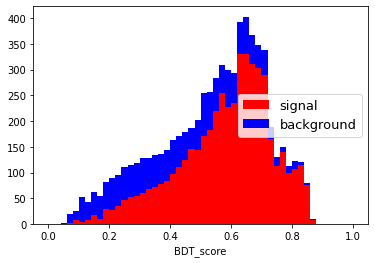

In [43]:
bdt_svb_plot(lc_test_results)
#bdt_svb_plot(p_test_results, is_log=True)

/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:300: RuntimeWarning: invalid value encountered in double_scalars
  mc_percent_error = [y/z for y, z in zip(mc_total_error, n)]


total selected = 125.27833955130534


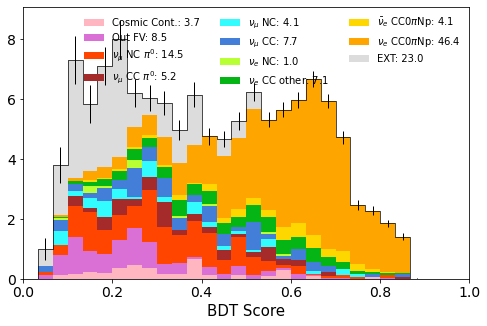

total selected = 47.610909926331516


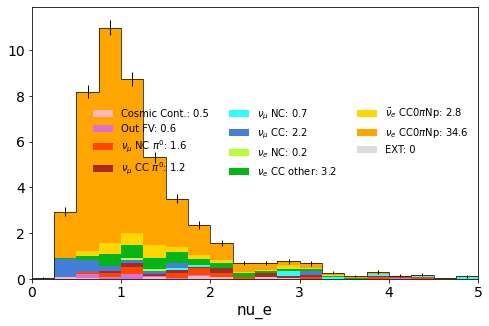

In [44]:
# loose cuts bdt results split into infv, outfv, cosmic, and ext events
# NOTE: this will be half of the full dataset
datasets_bdt = split_events(lc_test_results)

x = plot_mc('BDT_score', 30, 0, 1, '', datasets_bdt, ISRUN3, norm='data', x_label="BDT Score")
x  = plot_mc('nu_e', 20, 0, 5, 'BDT_score > 0.5', datasets_bdt, ISRUN3, norm='data', x_label="")

#plot_mc('nu_e', 20, 0, 5, 'BDT_score > 0.5', datasets_bdt, 'BDT', True, False, ISRUN3, 'totweight_overlay', ylim=60)
#plot_mc('nu_e', 20, 0, 5, 'BDT_score > 0.5', datasets_bdt, 'BDT', False, False, ISRUN3, 'totweight_overlay', ylim=140)

In [45]:
# note test sample is equivalent regardless of query 
# as query step happens after the initial split of testing and training data
full_test_df = bdt_lc[3]

Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


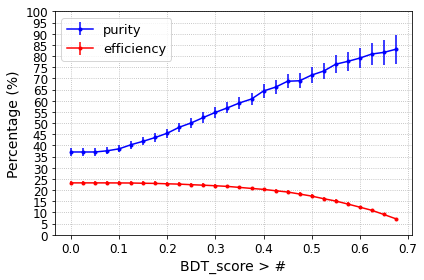

In [46]:
bdt_pe_plot(lc_test_results, np.arange(0, 0.7, 0.025), full_test_df, ISRUN3, split=split, ISDATA=ISDATA, save=False)
#bdt_pe_plot(p_test_results, np.arange(0, 0.7, 0.025), full_test_df, ISDATA)

In [47]:
xvals = np.arange(0, 0.8, 0.025)


#gen_num = sum(test_df.query('is_signal==1 or is_cont_signal==1')['totweight_overlay'])
gen_num = sum(generated_signal(ISRUN3, 'nu_e', 1, 0, 10))*split
eff_box = sum(full_test_df.query(BOX_CUTS+' and is_signal==1')['totweight_overlay'])/gen_num * 100

tot_sel = np.nansum(full_test_df.query(BOX_CUTS)['weight']) # EXT does not have totweight_overlay 
pur_box = sum(full_test_df.query(BOX_CUTS+' and is_signal==1')['totweight_overlay']) / tot_sel * 100

results_box = [pur_box, eff_box]

# with stat errors on the linear performance 
e = eff_box/100

eff_err = math.sqrt( (e*(1-e)) / gen_num ) * 100
pur_err = math.sqrt(sum(full_test_df.query(BOX_CUTS+' and is_signal==1')['totweight_overlay'])) / tot_sel * 100

results_box_err = [pur_err, eff_err]

Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


In [48]:
lc_bdt_pe = bdt_pe(bdt_lc[0], xvals, generated_signal(ISRUN3, 'nu_e', 1, 0, 10), full_test_df, split=split)


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


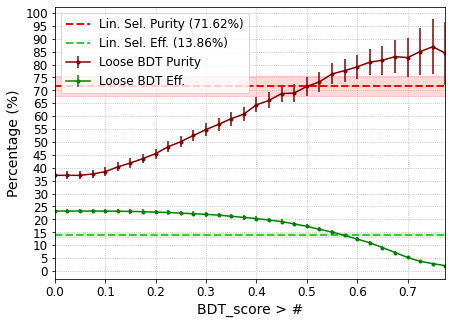

In [49]:
bdt_box_plot(lc_bdt_pe, xvals, ISRUN3, results_box=results_box, results_box_err=results_box_err, save=False, 
            save_label="FHC")
#bdt_box_plot(lc_bdt_pe, results_box, xvals, second_results_bdt=p_bdt_pe)


## Cross-Validation

In [50]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [51]:
ISNUEBAR = False
ISDATA = False

In [52]:
#if ISDATA:
#    mc_weight = 'totweight_data'
#else:

mc_weight = 'totweight_overlay'

In [53]:
splits = 2
repeats = 20
cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=36851234)

bdt_score_arr = np.arange(0, 0.8, 0.025)

In [54]:
mc['weight'] = mc['totweight_overlay']
ext['weight'] = ext['pot_scale_overlay']

In [55]:
df_cv = pd.concat([mc, ext], ignore_index=True)

/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [56]:
#cosmic cont. in FV signal definition for convenience in efficiency calculations later
# updated for modified signal
df_cv['is_cont_signal'] = np.where(((df_cv.nu_pdg == 12) & (df_cv.ccnc == 0) & (df_cv.nproton > 0) & (df_cv.npion == 0) & (df_cv.npi0 == 0)
                               & (df_cv.nu_purity_from_pfp <= 0.5)
                               & (10 <= df_cv.true_nu_vtx_x) & (df_cv.true_nu_vtx_x <= 246)
                                & (-106 <= df_cv.true_nu_vtx_y) & (df_cv.true_nu_vtx_y <= 106)
                               & (10 <= df_cv.true_nu_vtx_z) & (df_cv.true_nu_vtx_z <= 1026)
                                    & (df_cv.opening_angle > -0.9) & (df_cv.opening_angle < 0.9)), 1, 0)

#true signal definition
df_cv['is_signal'] = np.where(((df_cv.nu_pdg == 12) & (df_cv.ccnc == 0) & (df_cv.nproton > 0) & (df_cv.npion == 0) & (df_cv.npi0 == 0)
                               & (df_cv.nu_purity_from_pfp > 0.5)
                               & (10 <= df_cv.true_nu_vtx_x) & (df_cv.true_nu_vtx_x <= 246)
                                & (-106 <= df_cv.true_nu_vtx_y) & (df_cv.true_nu_vtx_y <= 106)
                               & (10 <= df_cv.true_nu_vtx_z) & (df_cv.true_nu_vtx_z <= 1026)
                                & (df_cv.opening_angle > -0.9) & (df_cv.opening_angle < 0.9)), 1, 0)

if ISNUEBAR:
    #bdt signal definition (doesn't distinguish between nue and nuebar)
    df_cv['is_nuebar_signal'] = np.where((((df_cv.nu_pdg == 12) | (df_cv.nu_pdg == -12)) & (df_cv.ccnc == 0) & (df_cv.nproton > 0) & (df_cv.npion == 0) & (df_cv.npi0 == 0)
                                   & (df_cv.nu_purity_from_pfp > 0.5)
                                   & (10 <= df_cv.true_nu_vtx_x) & (df_cv.true_nu_vtx_x <= 246)
                                    & (-106 <= df_cv.true_nu_vtx_y) & (df_cv.true_nu_vtx_y <= 106)
                                   & (10 <= df_cv.true_nu_vtx_z) & (df_cv.true_nu_vtx_z <= 1026)
                                          & (df_cv.opening_angle > -0.9) & (df_cv.opening_angle < 0.9)), 1, 0)

In [57]:
# change query depending on pre-BDT cuts
q = BDT_LOOSE_CUTS

scale_weight = len(df_cv.query(q + ' and is_signal == 0')) / len(df_cv.query(q + ' and is_signal == 1'))

In [58]:
scale_weight

0.406163894274926

In [59]:
# updated for modified signal
varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance", #"tksh_angle", 
    "subcluster", "trkshrhitdist2"]
    
#model params
params = {
    'eta': 0.02,
    'tree_method': 'exact',
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'silent': 1,
    'min_child_weight': 1,
    'seed': 2002,
    'gamma': 1,
    'max_delta_step': 0,
    'scale_pos_weight': scale_weight,
    'eval_metric': ['error', 'auc', 'aucpr']
}

In [60]:
final_purity = []
final_efficiency=[]
fp_err = []
fe_err = []
fp_2=[]
fe_2=[]
fp_err2 = []
fe_err2 = []

box_pur = []
box_eff = []
boxp_err = []
boxe_err = []

for train_index, test_index in cv.split(df_cv, df_cv['is_signal']):
    train, test = df_cv.iloc[train_index], df_cv.iloc[test_index]    
    
    if ISRUN3:
        if ISNUEBAR:
            p_rounds = 200
            lc_rounds = 300
        else:
            p_rounds = 300
            lc_rounds = 200
    else:
        p_rounds = 300
        lc_rounds = 200
        
    #bdt_cv_p = bdt_raw_results(train, test, PRE_QUERY, varlist, params, p_rounds, ISNUEBAR)
    bdt_cv_lc = bdt_raw_results(train, test, BDT_LOOSE_CUTS, varlist, params, lc_rounds, ISNUEBAR)
    
    # saves purity, efficiency and respective errors on current test sample for loose cuts BDT
    pur, pur_err, eff, eff_err = bdt_pe(bdt_cv_lc[0], bdt_score_arr, 
                                        generated_signal(ISRUN3, 'nu_e', 1, 0, 10)*overlay_scale_to_data, 
                                        test, split=split)
    
    final_purity.append(pur)
    final_efficiency.append(eff)
    fp_err2.append(pur_err)
    fe_err2.append(eff_err)

    # saves purity, efficiency and respective errors on current test sample for preselection BDT
    #pur2, pur_err2, eff2, eff_err2 = bdt_pe(bdt_cv_p[0], bdt_score_arr, test, ISRUN3, split=split)
    #fp_2.append(pur2)
    #fe_2.append(eff2)
    #fp_err2.append(pur_err2)
    #fe_err2.append(eff_err2)

    # saves purity and efficiency and respective errors for linear box cut selection performance on current test sample
    sig_sel = sum(test.query(BOX_CUTS+' and is_signal==1')[mc_weight])
    tot_sel = sum(test.query(BOX_CUTS)['weight'])
    tot_sig = sum(generated_signal(ISRUN3, 'nu_e', 1, 0, 10))*split
    #tot_sig = sum(test.query('is_signal==1 or is_cont_signal==1')[mc_weight])
    
    p = sig_sel / tot_sel
    e = sig_sel / tot_sig
    
    box_pur.append(p * 100)
    box_eff.append(e * 100)
    
    boxp_err.append(math.sqrt(sig_sel) / tot_sel * 100)
    boxe_err.append(math.sqrt((e * (1-e)) / tot_sig) * 100)

/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['pot_scale'] = pot_scale
/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/selection_functions.py:1948: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['totweight_overlay'] = df_signal['ppfx_cv']*df_signal['weightSplineTimesTune']*df_signal['pot_scale']


Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22
Double check! Overlay POT = 2.33652e+21
Double check! Intrinsic POT = 2.37838e+22


In [61]:
# averages results column-wise which is equivalent to averaging results over the same BDT_score cut
results_bdt = [np.mean(final_purity, axis=0), np.full(len(bdt_score_arr), 0), 
               np.mean(final_efficiency, axis=0), np.full(len(bdt_score_arr), 0)]
second_results_bdt = [np.mean(fp_2, axis=0), np.full(len(bdt_score_arr), 0), 
                      np.mean(fe_2, axis=0), np.full(len(bdt_score_arr), 0)]



# linear box cut selection is a normal average over each distinct test sample
results_box = [np.mean(box_pur), np.mean(box_eff)]
results_box_err = [np.mean(boxp_err), np.mean(boxe_err)]

/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/uboone/app/users/kmiller/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
for i in range(len(bdt_score_arr)): 
    if bdt_score_arr[i]>=0.4: 
        print("BDT score > "+str(round(bdt_score_arr[i], 3)))
        print("efficiency = "+str(round(results_bdt[2][i], 1)))
        print("purity = "+str(round(results_bdt[0][i], 1)))

BDT score > 0.4
efficiency = 20.1
purity = 65.0
BDT score > 0.425
efficiency = 19.5
purity = 67.0
BDT score > 0.45
efficiency = 18.8
purity = 69.3
BDT score > 0.475
efficiency = 18.0
purity = 71.4
BDT score > 0.5
efficiency = 17.0
purity = 73.5
BDT score > 0.525
efficiency = 15.9
purity = 75.3
BDT score > 0.55
efficiency = 14.7
purity = 77.3
BDT score > 0.575
efficiency = 13.4
purity = 79.1
BDT score > 0.6
efficiency = 12.0
purity = 80.8
BDT score > 0.625
efficiency = 10.4
purity = 82.5
BDT score > 0.65
efficiency = 8.9
purity = 84.0
BDT score > 0.675
efficiency = 7.2
purity = 85.5
BDT score > 0.7
efficiency = 5.6
purity = 86.9
BDT score > 0.725
efficiency = 4.1
purity = 88.6
BDT score > 0.75
efficiency = 2.7
purity = 90.6
BDT score > 0.775
efficiency = 1.7
purity = 91.9


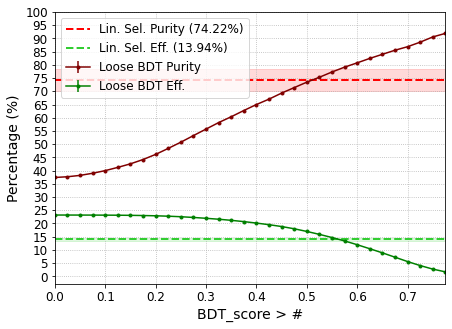

In [63]:
bdt_box_plot(results_bdt, bdt_score_arr, ISRUN3, results_box=results_box, results_box_err=results_box_err, 
            save=False, save_label="FHC_crossval") 
             #second_results_bdt=second_results_bdt)